# setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/UCL/STAT0035/bnn-regression')

In [ ]:
%%capture
!pip install dm-haiku

In [ ]:
# use TPUs
# - https://github.com/google/jax/pull/8485/commits/61a3abbeab027d0b4ad868de1cbb6a542cd19c4a
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu('tpu_driver-0.1dev20211031')

# use float32 matmul on TPU
import jax
jax.config.update('jax_default_matmul_precision', 'highest')

# check the number of GPU / TPU devices
n_devices = jax.local_device_count() 
print('num. devices:', n_devices)

num. devices: 8


# imports

In [ ]:
# system imports
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.flatten_util import ravel_pytree
import pickle

# relative imports
from core import models, distributions, datasets, utils, metrics
from core.sgd import train_sgd
from core.rwmh import rwmh_sampler
from core.hmc import hmc_sampler
from core.nuts import nuts_sampler
from core.utils import pmap_

In [ ]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

# dataset

In [ ]:
ds_path = 'naval_dataset/data.txt'
key = jax.random.PRNGKey(0)
(x_train, y_train), (x_test, y_test) = datasets.load_naval_dataset(ds_path, key)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(10740, 14) (10740,) (1194, 14) (1194,)


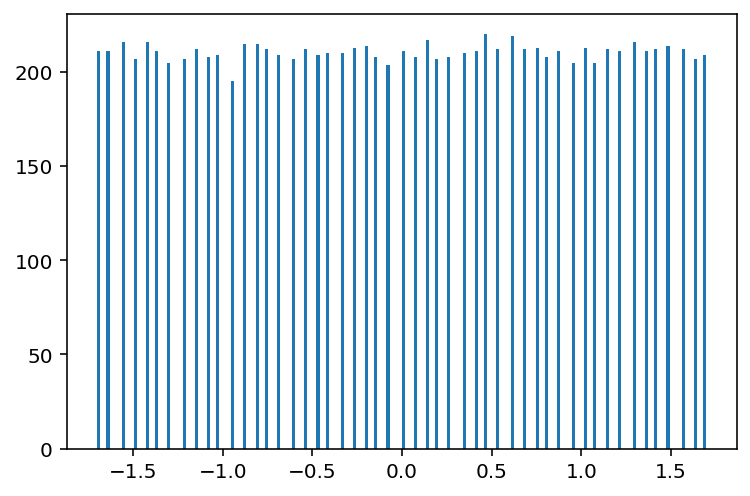

In [ ]:
plt.hist(y_train, bins=200)
plt.show()

# model

In [ ]:
# define model
key = jax.random.PRNGKey(0)
layer_dims = 1*[50]
init_sd = 0.1
prior_sd = 1
predict_fn, params_init = models.make_nn(key, x_train, layer_dims)
n_params = len(params_init)
log_likelihood_fn = distributions.make_gaussian_log_likelihood(x_train, y_train, predict_fn)
log_prior_fn = distributions.make_gaussian_log_prior(prior_sd)
log_posterior_fn = distributions.make_log_posterior(log_likelihood_fn, log_prior_fn)

In [ ]:
# test model
print('num. params: ', n_params)

# TEST: prior, likelihood, posterior
print('PDF test: ', log_prior_fn(params_init), log_likelihood_fn(params_init), log_posterior_fn(params_init))

num. params:  852
PDF test:  -802.66125 -111650.05 -112452.71


# training

In [45]:
# create multiple chains using each method to allow cmputing r_hat
n_chains = 8

# number of samples to keep from each chain
n_samples = 100

## random initialization

In [46]:
key = jax.random.PRNGKey(0)
train_keys = jax.random.split(key, n_chains)
params_start = init_sd*jax.random.normal(key, [n_chains, n_params])

## SGD

In [47]:
%%time
n_epochs = 10_000
ll_start = 1e-5
ll_stop = 1e-8
params_sgd, sgd_loss = pmap_(train_sgd, [params_start], [log_posterior_fn, n_epochs, ll_start, ll_stop])
chains_sgd = params_sgd[:, None, :]

CPU times: user 1.01 s, sys: 1.25 s, total: 2.26 s
Wall time: 3.4 s


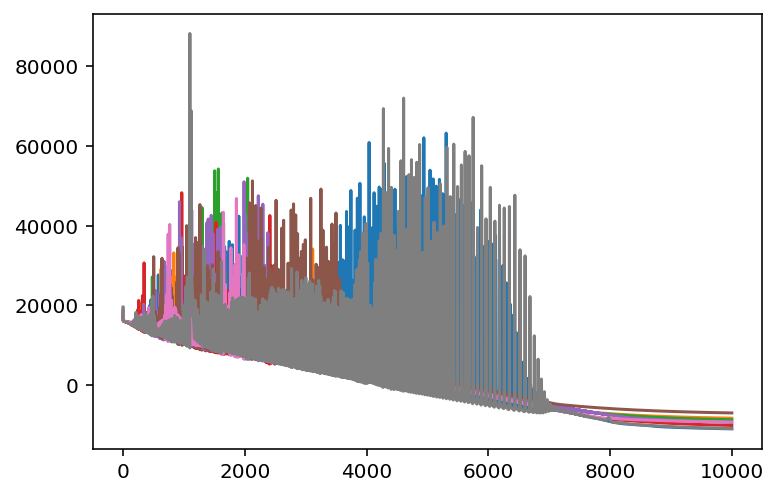

In [48]:
fig, ax = plt.subplots()
for i in range(n_chains):
    ax.plot(sgd_loss[i], alpha=1)
plt.show()

## RWMH

In [49]:
%%time
step_size = 1e-5
n_blind_steps = 10_000
chains_rwmh, avg_accept_prob = pmap_(rwmh_sampler, [train_keys, params_start], [log_posterior_fn, n_samples, n_blind_steps, step_size])
print(f'Avg. accept. prob.: {avg_accept_prob.mean():.2%}')

Avg. accept. prob.: 97.94%
CPU times: user 19.2 s, sys: 51.8 s, total: 1min 10s
Wall time: 2min 2s


## HMC

In [50]:
%%time
step_size = 1e-6
n_leapfrog_steps = 10_000
chains_hmc, avg_accept_prob = pmap_(hmc_sampler, [train_keys, params_start], [log_posterior_fn, n_samples, n_leapfrog_steps, step_size])
chains_hmc = jnp.array(chains_hmc)
print(f'Avg. accept. prob.: {avg_accept_prob.mean():.2%}')

Avg. accept. prob.: 96.51%
CPU times: user 1min 21s, sys: 3min 51s, total: 5min 13s
Wall time: 8min 58s


## NUTS

In [44]:
%%time
step_size = 1e-6
max_depth = 8
print('max leapfrog steps: ', 2**max_depth)
key = jax.random.PRNGKey(0)
chains_nuts, ratio_valid_samples, total_stops = pmap_(nuts_sampler, [train_keys, params_start], [log_posterior_fn, n_samples, step_size, max_depth])
chains_nuts = jnp.array(chains_nuts)
total_stops = total_stops.sum(0)
print(f'Proportion valid: {ratio_valid_samples.mean():.2%}')
print(f'Termination: max_steps={total_stops[0]}, u-turn={total_stops[1]}, max_error={total_stops[2]}.')


max leapfrog steps:  256
Proportion valid: 99.76%
Termination: max_steps=200, u-turn=0, max_error=0.
CPU times: user 7.72 s, sys: 5.72 s, total: 13.4 s
Wall time: 23.2 s


## save training output

In [ ]:
chains_dict = {
    'sgd': chains_sgd,
    'rwmh': chains_rwmh,
    'hmc': chains_hmc,
    'nuts': chains_nuts,
}
os.makedirs('tmp', exist_ok=True)
with open('tmp/chains_dict.npy', 'wb') as file:
    pickle.dump(chains_dict, file)

# load training output

In [ ]:
with open('tmp/chains_dict.npy', 'rb') as file:
    chains_dict = pickle.load(file)
for name, chains in chains_dict.items():
    print(name, chains.shape)

sgd (3, 1, 852)
rwmh (3, 100, 852)
hmc (3, 100, 852)
mixed (3, 100, 852)


In [ ]:
chains_dict['hmc'] = chains_hmc

# burn-in

In [ ]:
burn_in = 20
for name in chains_dict.keys():
    chain_dict[name] = chain_dict[name][burn_in:]

# diagnostics

## history of a single parameter

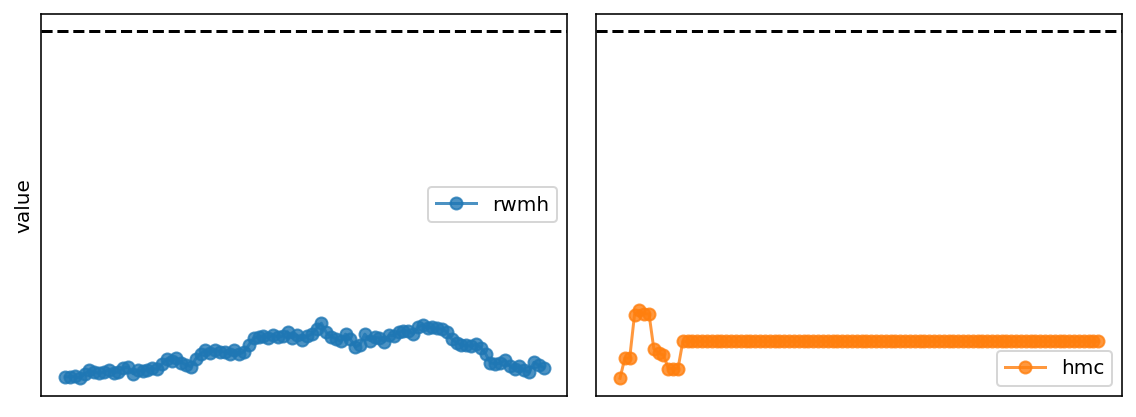

In [ ]:
chain_idx = 0
param_idx = 0
n_points = 100
fig, axs = plt.subplots(1, 2, figsize=[8, 3])
axs = axs.flatten()
chains_to_show = ['rwmh', 'hmc']
for i, name in enumerate(chains_to_show):
    chains = chains_dict[name]
    param = chains[chain_idx, :, param_idx]
    line, = axs[i].plot(param[:n_points].tolist(), 'o-', alpha=0.8, label=name, color=f'C{i}')
    axs[i].axhline(y=chains[:, :, param_idx].mean(), linestyle="--", color='black')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].legend()
    if i in [2, 3]: axs[i].set_xlabel('step')
    if i in [0, 2]: axs[i].set_ylabel('value')
plt.tight_layout()
# plt.savefig('plots/mh_parameter_history.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## autocorrelation

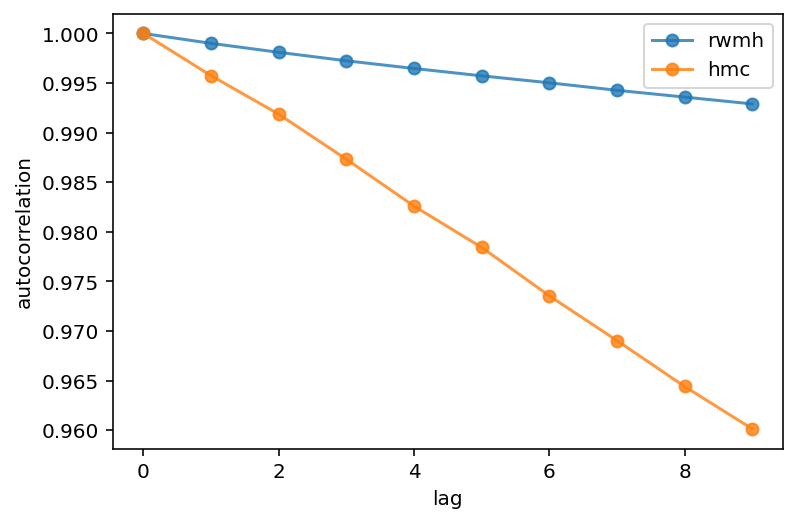

In [ ]:
fig, ax = plt.subplots()

# autocorrelation
f = lambda x: x
chains_to_show = ['rwmh', 'hmc']
for i, name in enumerate(chains_to_show):
    chains = chains_dict[name]
    r = metrics.autocorr(chains, f, 10)
    ax.plot(r.tolist(), 'o-', alpha=0.8, label=name)
    # ax.axhline(y=0, color='black', linestyle="--")
ax.legend()
ax.set_xlabel('lag')
ax.set_ylabel('autocorrelation')

# plt.savefig('plots/rhat_autocorr.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## $\hat{R}$

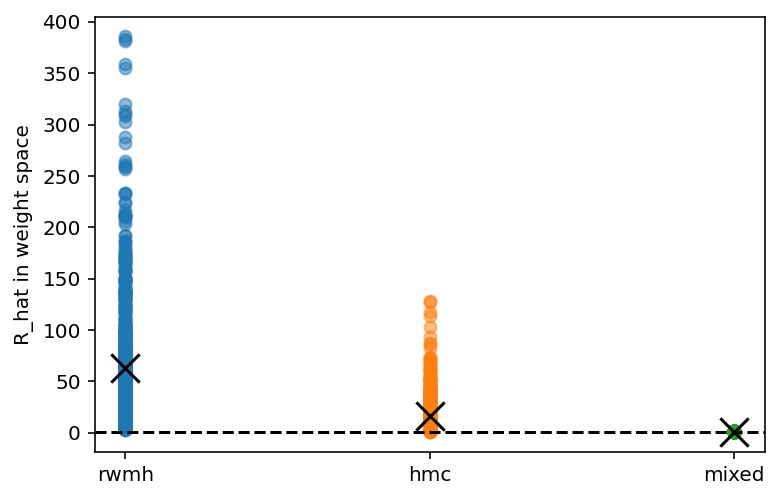

In [ ]:
fig, ax = plt.subplots()

# R_hat
f = lambda x: x
chains_to_show = ['rwmh', 'hmc', 'mixed']
for i, name in enumerate(chains_to_show):
    chains = chains_dict[name]
    r = metrics.r_hat(chains, f)
    ax.scatter([i]*len(r), r.tolist(), alpha=0.5)
    ax.scatter(i, r.mean(), color='black', marker='x', s=200, zorder=2)
ax.set_xticks(range(len(chains_to_show)))
ax.set_xticklabels(chains_to_show)
ax.set_ylabel('R_hat in weight space')
ax.axhline(y=1, color='black', linestyle="--")

# plt.savefig('plots/rhat_autocorr.pdf', bbox_inches='tight', pad_inches=0)
# ax.set_yscale('log')
# ax.set_ylim([0.99, 1.16])
plt.show()

## Likelihood of test data

In [ ]:
# function like 'predict_fn' but takes in an array an unravels it
def predict_from_array(x, params_flat):
    params_tree = unravel_fn(params_flat)
    y_hat = predict_fn(x, params_tree)
    return y_hat


def chain_to_loglike(chain):
    # compute y_hat for each node in the chain
    predict_vmap = jax.vmap(predict_from_array, [None, 0])
    y_hat = predict_vmap(x_test, chain)
    mean, std = y_hat[:, :, 0], y_hat[:, :, 1]

    # compute likelihood for each node in the chain
    log_likelihood = distributions.gaussian_log_pdf(y_test[None, :], mean, std)

    # average the likelihood across nodes
    log_likelihood = jax.scipy.special.logsumexp(log_likelihood, 0) - jnp.log(len(chain))

    # get total likelihood of all data points
    log_likelihood = log_likelihood.sum()
    return log_likelihood


for i, (name, chains) in enumerate(chains_dict.items()):    
    ll = jax.vmap(chain_to_loglike)(chains)
    print(f'{name}: {ll.mean():.3f} ± {ll.std():.4f}')

sgd: 1136.025 ± 71.4370
rwmh: 1224.624 ± 71.5320
hmc: 3680.931 ± 261.4433
mixed: 3330.575 ± 64.3102


## Distribution of parameters

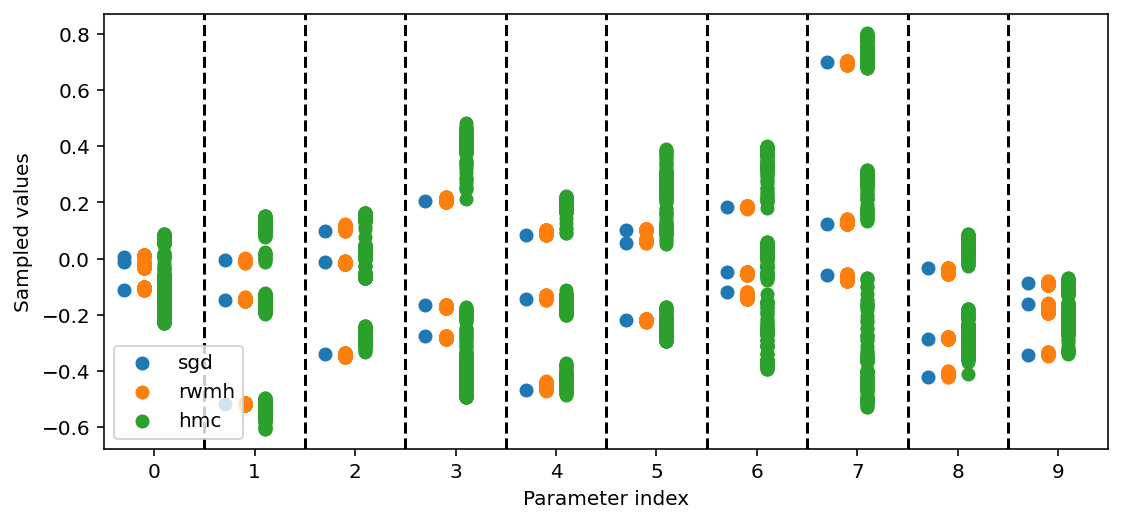

In [ ]:
fig, ax = plt.subplots(figsize=[9, 4])
d = 10 # num. of params to plot
chains_to_show = ['sgd', 'rwmh', 'hmc']
for i, name in enumerate(chains_to_show):
    chains = chains_dict[name]
    M, N, D = chains.shape
    y_ = chains.reshape([M*N, D])[:, :d]
    x_ = jnp.zeros([len(y_), 1]) + jnp.arange(d)[None] + (0.2*i - 0.3)
    ax.scatter(x_, y_, c=f'C{i}', alpha=1, label=name)

for i in range(d-1):
    ax.axvline(x=i+0.5, linestyle="--", color='black')

ax.set_xlim([-0.5, d-0.5])
ax.set_xticks(range(d))
ax.set_xlabel('Parameter index')
ax.set_ylabel('Sampled values')
ax.legend(loc='lower left')
# plt.savefig('plots/parameter_distribution.pdf', bbox_inches='tight', pad_inches=0)
plt.show()